In [1]:
import os
import glob
import json
from quickstats.components.processors import RooProcessor
import sys
import pandas as pd
from IPython.display import display
from pdb import set_trace
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

Welcome to JupyROOT 6.26/04

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Process ntuples

In [2]:
def get_sample_files(ntuple_config):
    sample_names, sample_summary = {}, {}
    for process in ntuple_config['processes']:
        subprocesses = ntuple_config['processes'][process]
        matched_paths = []
        sample_names[process], sample_summary[process] = {}, {}
        for subprocess in subprocesses:
            subprocessfiles = ntuple_config['process_files'][process][subprocess]
            for subprocessfile in subprocessfiles:
                file_expr = os.path.join(ntuple_config['ntuple_dir'], ntuple_config['ntuple_subdir'][process], subprocessfile)
                matched_paths += [i for i in glob.glob(file_expr) if 'backup' not in i]
            sample_names[process][subprocess] = matched_paths
            sample_summary[process][subprocess] = len(matched_paths)
            
    return sample_names, sample_summary

In [3]:
 def process_ntuple(pocessor_config, ntuple_config, sample_names, outdir):
    processor = RooProcessor(pocessor_config)
    processor.global_variables['outdir'] = os.path.join(outdir, "raw")
    ntuple_dir = ntuple_config['ntuple_dir']
    for process in sample_names:
        for subprocess in sample_names[process]:
            files = sample_names[process][subprocess]
            processor.global_variables['process'] = process
            processor.global_variables['subprocess'] = subprocess
            processor.run(files)
    return processor.global_variables['outdir']

In [4]:
def process_samples(task):
    pocessor_config = task['RooProcessorCard']
    outdir = task['outdir']
    ntuple_config = json.load(open(task['SampleCard']))

    sample_names, sample_summary = get_sample_files(ntuple_config)
    outdir = process_ntuple(pocessor_config, ntuple_config, sample_names, outdir)

    return {'outdir': outdir,
            'sample_summary': pd.DataFrame.from_dict(sample_summary),
            'processes_hierarchy': ntuple_config['processes']
           }


In [11]:
# input dir is hardcoded in `SampleCard`

outbasedir = "/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/"
task = {
    'RooProcessorCard': "config/Hmumu_CUT.txt",
    'outdir': os.path.join(outbasedir, "processed", "v1"),
    'SampleCard': "config/Hmumu_ntuple_v1.json",
    }

summary = process_samples(task)

INFO: Professing files
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427305_tree_output.root/user.zhangr.29859127._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427338_tree_output.root/user.zhangr.29859128._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427338_tree_output.root/user.zhangr.29859128._000002.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427394_tree_output.root/user.zhangr.29832879._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427394_tree_output.root/user.zhangr.29832879._000002.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427405_tree_output.root/user.zhangr.29833001._000001

INFO: Writing output to `/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/processed/v1/raw/data_periodD.root`.
INFO: Task finished. Total time taken: 2.028 s.
INFO: Professing files
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427305_tree_output.root/user.zhangr.29859127._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427338_tree_output.root/user.zhangr.29859128._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427338_tree_output.root/user.zhangr.29859128._000002.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427394_tree_output.root/user.zhangr.29832879._000001.tree_output.root`
	`/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/ntuple/v1/data/user.zhangr.HmmData22_v1_00427394_tree_output.root/user.zhangr.29832879._000002.tree

INFO: Writing output to `/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/processed/v1/raw/data_periodE.root`.
INFO: Task finished. Total time taken: 7.289 s.


In [12]:
display(summary['sample_summary'])
summary['outdir'], summary['processes_hierarchy']

data
periodD    47
periodE    53

('/eos/atlas/unpledged/group-wisc/users/zhangr/Hmumu/processed/v1/raw',
 {'data': ['periodD', 'periodE']})

## Plotting

In [23]:
from quickstats.plots import Histo1DPlot
from quickstats.interface.root.data_conversion import root2numpy, root2dataframe

def load_root():
    variables = [
        'Event_ActualMu',
        'Event_AverageMu',
        'Event_Centrality',
        'Event_CorrActualMu',
        'Event_CorrAverageMu',
        'Event_HasBJet',
        'Event_Ht',
        'Event_MET',
        'Event_MET_Phi',
        'Event_MET_Sig',
        'Event_MET_Sig_CP',
        'Event_PT_MuMuj1',
        'Event_PT_MuMuj2',
        'Event_PT_MuMujj',
        'Event_RandomVal',
        'Event_Y_MuMuj1',
        'Event_Y_MuMuj2',
        'Event_Y_MuMujj',
        'FSR_DeltaR',
        'FSR_Et',
        'FSR_Eta',
        'FSR_IsPhoton',
        'FSR_Phi',
        'FSR_Type',
        'FSR_f1',
        'Jets_DeltaEta_jj',
        'Jets_DeltaPhi_jj',
        'Jets_DeltaR_jj',
        'Jets_E_Lead',
        'Jets_E_Lead_Truth',
        'Jets_E_Sub',
        'Jets_E_Sub_Truth',
        'Jets_Eta_Lead',
        'Jets_Eta_Lead_Truth',
        'Jets_Eta_Sub',
        'Jets_Eta_Sub_Truth',
        'Jets_Eta_jj',
        'Jets_Minv_jj',
        'Jets_NTracks_Lead',
        'Jets_NTracks_Sub',
        'Jets_PT_Lead',
        'Jets_PT_Lead_Truth',
        'Jets_PT_Sub',
        'Jets_PT_Sub_Truth',
        'Jets_PT_jj',
        'Jets_PartonID_Lead',
        'Jets_PartonID_Sub',
        'Jets_PassFJVT_Lead',
        'Jets_PassFJVT_Sub',
        'Jets_Phi_Lead',
        'Jets_Phi_Lead_Truth',
        'Jets_Phi_Sub',
        'Jets_Phi_Sub_Truth',
        'Jets_Phi_jj',
        'Jets_QGTag_BDTScore_Lead',
        'Jets_QGTag_BDTScore_Sub',
        'Jets_TracksC1_Lead',
        'Jets_TracksC1_Sub',
        'Jets_TracksWidth_Lead',
        'Jets_TracksWidth_Sub',
        'Jets_TruthDR_Lead',
        'Jets_TruthDR_Sub',
        'Jets_Weight_NChargedExp_Down_Lead',
        'Jets_Weight_NChargedExp_Up_Lead',
        'Jets_Weight_NChargedME_Down_Lead',
        'Jets_Weight_NChargedME_Up_Lead',
        'Jets_Weight_NChargedPDF_Down_Lead',
        'Jets_Weight_NChargedPDF_Up_Lead',
        'Jets_Weight_TrackEfficiency_Lead',
        'Jets_Weight_TrackFakes_Lead',
        'Jets_jetMultip',
        'Muons_Charge_Lead',
        'Muons_Charge_Sub',
        'Muons_CosThetaStar',
        'Muons_DeltaEta_MuMu',
        'Muons_DeltaPhi_MuMu',
        'Muons_DeltaR_MuMu',
        'Muons_Eta_Lead',
        'Muons_Eta_Sub',
        'Muons_Minv_MuMu',
        'Muons_Minv_MuMu_Fsr',
        'Muons_Minv_MuMu_Fsr_Sigma',
        'Muons_Minv_MuMu_Sigma',
        'Muons_Multip',
        'Muons_PT_Lead',
        'Muons_PT_Sub',
        'Muons_Phi_Lead',
        'Muons_Phi_Sub',
        'Muons_TruthOrigin_Lead',
        'Muons_TruthOrigin_Sub',
        'Muons_TruthType_Lead',
        'Muons_TruthType_Sub',
        'Muons_Type_Lead',
        'Muons_Type_Sub',
        'Z_Eta',
        'Z_Eta_FSR',
        'Z_PT',
        'Z_PT_FSR',
        'Z_Phi',
        'Z_Phi_FSR',
        'Z_Y',
        'Z_Y_FSR',
        'dimuon_good_eta',
        'dimuon_good_mass',
        'dimuon_good_pt',
        'dimuon_are_good',
    ]

    all_data = {}
    for process in summary['processes_hierarchy']:
        for subprocess in summary['processes_hierarchy'][process]:
            df = root2dataframe(summary['outdir'] + '/' + '_'.join([process, subprocess]) + '.root', 'tree_NOMINAL', columns=variables)
            all_data['_'.join([process, subprocess])] = df
    return all_data

def eq(all_data, var, value):
    cut_data = {}
    for key in all_data:
        cut_data[key] = all_data[key][all_data[key][var]==value]
    return cut_data
def gt(all_data, var, value):
    cut_data = {}
    for key in all_data:
        set_trace()
        cut_data[key] = all_data[key][all_data[key][var] > value]
    return cut_data
def lt(all_data, var, value):
    cut_data = {}
    for key in all_data:
        set_trace()
        cut_data[key] = all_data[key][all_data[key][var] < value]
    return cut_data

In [14]:
all_data = load_root()

In [24]:
cut_data = eq(all_data, 'dimuon_are_good', 1)

In [26]:
def plot(all_data, var, xrange=None, filename=None):
    data = {
        "signal": all_data['data_periodD'][var],
        "background": all_data['data_periodE'][var],
    }
    analysis_label_options = {
        "energy": "13.6 TeV",
        "lumi": "xxx fb$^{-1}$"
    }
    styles = {
        'legend': {
            'loc': (0.7, 0.8)
        }
    }
    label_map = {
        "signal": "Period D",
        "background": "Period E"
    }
    plotter = Histo1DPlot(data, label_map=label_map,
                          styles=styles, analysis_label_options=analysis_label_options)
    ax = plotter.draw(["background", "signal"], xlabel=var,
                         bins=40, stacked=True, range=xrange, ypad=0.2)
    if filename:
        plt.savefig(filename, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

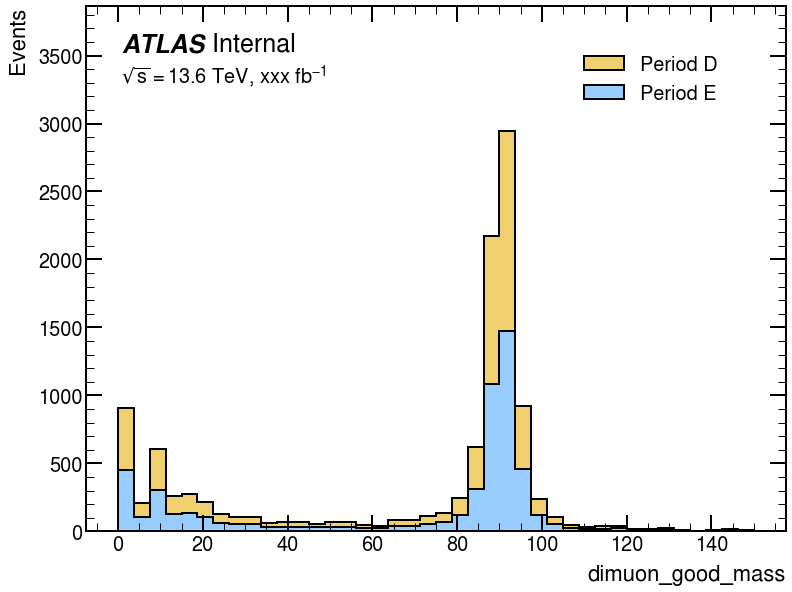

In [28]:
plot(cut_data, 'dimuon_good_mass', xrange=(0, 150))
# plot(all_data, 'dimuon_are_good', xrange=(-1, 2))
